\tableofcontents
\newpage

# JLKK ht
<code>
2015-16</code>

## Document level Twitter message sentiment analysis

Assignment is to build a model that predicts Twitter message categories (positive, neutral, negative). LinearSVC modelling was recommended.

## Given material

* training data: train_data.tsv
* test data: devel_data.tsv
* evaluation code: evaluator.py, this needs to be used in final evaluation, calculates F-score for positive and negative message predictions vs. real labels

## Shortly regarding the report content

The processing can be shortly seen on the first page Tabel of Contents.

This quite long report contains more detailed information how the data was processed and how the model was chosen. The numbering of titles and subtitles should make it easy for the reader/reviewer to follow the process and/or skip certain topics if needed. 

This report acts also as an opportunity document the learned topics that are easy to refer to and check when running into same tpoics in future assignments and courses. 

# Data processing

## Import of needed libraries

In [1]:
import matplotlib.pyplot as plt
import re
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, \
confusion_matrix

## Training data upload
Reading the comma separated train_data.tsv and removing irrelevan columns id1 and id2.

With this data format and column naming, the columns can be referred with either train_tweets.label or train_tweets['label'].

In [2]:
train_tweets = pd.read_csv('train_data.tsv', sep='\t', names=["id1","id2","label", \
                                                              "message"])
del train_tweets['id1'] # removing unnecessary first and second columns
del train_tweets['id2']
print train_tweets[:5]

      label                                            message
0  positive  Gas by my house hit $3.39!!!! I'm going to Cha...
1  negative  Iranian general says Israel's Iron Dome can't ...
2  positive  with J Davlar 11th. Main rivals are team Polan...
3  negative  Talking about ACT's && SAT's, deciding where I...
4  negative  They may have a SuperBowl in Dallas, but Dalla...


In [3]:
train_tweets.groupby('label').describe()

message
label                                                             
negative count                                                 854
         unique                                                843
         top     no way to underestimate the madness and cynici...
         freq                                                    2
neutral  count                                                3055
         unique                                               3033
         top     Real Madrid have signed a seven-year-old Argen...
         freq                                                    2
positive count                                                2266
         unique                                               2254
         top     The Bulls head to CLE Friday night. One night ...
         freq                                                    2

## Data preprocessing


Building and testing different text processing functions. Eventually combining the final function to process text prior vectorizing it.

### Tokenizing, splitting tweets into words

In [4]:
def split_into_words(text):
    message = unicode(text, 'utf8')  # into proper unicode
    return TextBlob(message).words # returns tweets tokenized into words

In [5]:
train_tweets.message.head()

0    Gas by my house hit $3.39!!!! I'm going to Cha...
1    Iranian general says Israel's Iron Dome can't ...
2    with J Davlar 11th. Main rivals are team Polan...
3    Talking about ACT's && SAT's, deciding where I...
4    They may have a SuperBowl in Dallas, but Dalla...
Name: message, dtype: object

In [6]:
train_tweets.message.head().apply(split_into_words)

0    [Gas, by, my, house, hit, 3.39, I, 'm, going, ...
1    [Iranian, general, says, Israel, 's, Iron, Dom...
2    [with, J, Davlar, 11th, Main, rivals, are, tea...
3    [Talking, about, ACT, 's, SAT, 's, deciding, w...
4    [They, may, have, a, SuperBowl, in, Dallas, bu...
Name: message, dtype: object

### Cleaning the tweet message

* processing tweet content
    * www.* or https?://* to URL    
    * @username to AT_USER
    * remove of additional white spaces
    * hash word (#word) replacement with plain word
* tokenization into words
* tokenization into lemmas, i.e. basic word form

In [7]:
# processes tweets into lower case and cleans irrelevant content
def processTweet(tweet):  
    # to lower case
    tweet = tweet.lower() 
    # www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)     
    # @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet) 
    # remove additional white space
    tweet = re.sub('[\s]+', ' ', tweet) 
    # replace #word with plain word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) 
    return tweet

In [8]:
# test the funcion
train_tweets.message.head(10).apply(processTweet)

0    gas by my house hit $3.39!!!! i'm going to cha...
1    iranian general says israel's iron dome can't ...
2    with j davlar 11th. main rivals are team polan...
3    talking about act's && sat's, deciding where i...
4    they may have a superbowl in dallas, but dalla...
5    im bringing the monster load of candy tomorrow...
6    apple software, retail chiefs out in overhaul:...
7    livewire nadal confirmed for mexican open in f...
8    iran us delisting mko from global terrorists l...
9    expect light-moderate rains over e. visayas; c...
Name: message, dtype: object

In [9]:
train_tweets.message[7]

'#Livewire Nadal confirmed for Mexican Open in February: Rafael Nadal is set to play at the Me... http://bit.ly/WY4Vjy\xc2\xa0 #LiveWireAthletics'

In [10]:
train_tweets.message.apply(processTweet)[7]

'livewire nadal confirmed for mexican open in february: rafael nadal is set to play at the me... URL livewireathletics'

### Combining functions together

In [11]:
def split_into_words(text):
    message = unicode(text, 'utf8').lower()
    processed_message=processTweet(message)
    words = TextBlob(processed_message).words # for each processed tweet, list of words
    return [word for word in words] # return list of words of the tweet

train_tweets.message.head(10).apply(split_into_words)

0    [gas, by, my, house, hit, 3.39, i, 'm, going, ...
1    [iranian, general, says, israel, 's, iron, dom...
2    [with, j, davlar, 11th, main, rivals, are, tea...
3    [talking, about, act, 's, sat, 's, deciding, w...
4    [they, may, have, a, superbowl, in, dallas, bu...
5    [im, bringing, the, monster, load, of, candy, ...
6    [apple, software, retail, chiefs, out, in, ove...
7    [livewire, nadal, confirmed, for, mexican, ope...
8    [iran, us, delisting, mko, from, global, terro...
9    [expect, light-moderate, rains, over, e, visay...
Name: message, dtype: object

### Lemmatizing the tweet messages

Instead of words, this function returns lemmas, the words in base form. This will be used in further tweet message pre-processing.

In [12]:
def split_into_lemmas(text):
    message = unicode(text, 'utf8').lower()
    processed_message=processTweet(message)
    words = TextBlob(processed_message).words   
    return [word.lemma for word in words] # return the words as lemma

train_tweets.message.head(10).apply(split_into_lemmas)

0    [gas, by, my, house, hit, 3.39, i, 'm, going, ...
1    [iranian, general, say, israel, 's, iron, dome...
2    [with, j, davlar, 11th, main, rival, are, team...
3    [talking, about, act, 's, sat, 's, deciding, w...
4    [they, may, have, a, superbowl, in, dallas, bu...
5    [im, bringing, the, monster, load, of, candy, ...
6    [apple, software, retail, chief, out, in, over...
7    [livewire, nadal, confirmed, for, mexican, ope...
8    [iran, u, delisting, mko, from, global, terror...
9    [expect, light-moderate, rain, over, e, visaya...
Name: message, dtype: object

# Data to vectors

In order to be able to analyze the tweets with machine learning model, the processed words/lemmas that represent each individual tweet need to be transformed into vectors.
The bag-of-words (BOW) model will be formed in these three steps:

1. Calculate term frequency: how many times does a word occur in each tweet message
2. Calculated inverse document frequency: when weighting the counts, the frequent tokens get lower weight
3. Normalize the vectors

Each vector has as many dimensions as there are unique words in the training data tweet messages, i.e. in document level corpus.

In [13]:
# using the split_into_lemmas for text processing
# forming the bag-of-words
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(train_tweets['message'])
print len(bow_transformer.vocabulary_)

14002


## Vectorizing example training data tweet message 

To better grasp the bag-of-words and vectorizing, next one example tweet message and its bag-of-words counts as a vector.

In [14]:
# the fourth tweet message taken as an example case
# alternative data column call: message_sample = train_tweets['message'][3]
message_sample = train_tweets.message[3]
print message_sample

Talking about ACT's && SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.


### Bag-of-words

 Transforming the tweet message wirt bow_transformer:

In [15]:
bow_sample = bow_transformer.transform([message_sample])
print "bow sample:\n",bow_sample 
print "\n bow sample shape: ",bow_sample.shape

bow sample:
  (0, 94)	2
  (0, 1060)	2
  (0, 1116)	1
  (0, 1420)	1
  (0, 1534)	1
  (0, 3258)	3
  (0, 3872)	1
  (0, 4721)	1
  (0, 5551)	1
  (0, 6308)	1
  (0, 8010)	1
  (0, 9113)	1
  (0, 10956)	1
  (0, 11957)	1
  (0, 12230)	1
  (0, 12599)	3
  (0, 13391)	1
  (0, 13550)	1

 bow sample shape:  (1, 14002)


Which words appear 3 times? Let's look at it and perform a sanity check.

In [16]:
print bow_transformer.get_feature_names()[3258]
print bow_transformer.get_feature_names()[12599]

college
to


In [17]:
print bow_transformer.vocabulary_['college']
print bow_transformer.vocabulary_['to']

3258
12599


The bag-of-words counts on document level, training data tweet messages, are a large, sparse matrix. Most of the elements are zero, only 0.13 % have other values.

In [18]:
messages_bow = bow_transformer.transform(train_tweets['message'])
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / \
                            (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (6175, 14002)
number of non-zeros: 113701
sparsity: 0.13%


### Tf.idf transformer

With TfidfTransformer, the term weighting and normalization can be done with tf.idf.

* tf = term frequency
* idf = inverse document frequency

In [19]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

With the tf.idf transformer, let's calculate the tf.idf for the example tweet message used earlier.

In [20]:
tfidf_sample = tfidf_transformer.transform(bow_sample)
print tfidf_sample

  (0, 13550)	0.183406944429
  (0, 13391)	0.14914600226
  (0, 12599)	0.190272303435
  (0, 12230)	0.220825446642
  (0, 11957)	0.286841022167
  (0, 10956)	0.154074391556
  (0, 9113)	0.11503867933
  (0, 8010)	0.12642275891
  (0, 6308)	0.078081397546
  (0, 5551)	0.132434809679
  (0, 4721)	0.207953234593
  (0, 3872)	0.264835830325
  (0, 3258)	0.599484521331
  (0, 1534)	0.286841022167
  (0, 1420)	0.0778829105984
  (0, 1116)	0.201945410247
  (0, 1060)	0.26222867465
  (0, 94)	0.172125964625


From this we can see the term frequency

* college (3258), idf=0.599484521331
* to (12599), idf=0.190272303435

Checking the tf.idf of the example tweet message's most frequent words "college" and "to". The smaller the number, the more often that word appears in the full list of training data corpus.

In [21]:
print tfidf_transformer.idf_[bow_transformer.vocabulary_['college']]
print tfidf_transformer.idf_[bow_transformer.vocabulary_['to']]

6.29443888722
1.99781202564


## Transforming all training data tweet messages with td.idf tranformer

The entire bag-of-words corpus into TF-IDF corpus at once

In [22]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(6175, 14002)


# Modelling with LinearSVC

## Finding the most suitable C value for the model, using 3 fold Cross Validation

In [23]:
from sklearn.svm import SVC,LinearSVC
from sklearn import svm, cross_validation
from sklearn.cross_validation import cross_val_score

for c in [0.1, 1, 10, 100, 1000]:
    clf=svm.LinearSVC(C=c)
    scores=cross_validation.cross_val_score(clf, messages_tfidf, \
                                            train_tweets.label, n_jobs=-1)
    print c, scores

0.1 [ 0.64271845  0.62876579  0.62275158]
1 [ 0.66553398  0.65257532  0.64073894]
10 [ 0.63349515  0.63216715  0.62032086]
100 [ 0.62038835  0.62293489  0.61011181]
1000 [ 0.61504854  0.6122449   0.60136121]


From the C values, 1 seems to fit best for the training data, so let's use that.

## Training the model

In [24]:
clf=svm.LinearSVC(C=1)
%time label_detector = clf.fit(messages_tfidf, train_tweets.label)

Wall time: 163 ms


### Testing with trainig data

Note! Testing with training data does not give any reliable results regarding the final model accuracy. Testing wit training data gives over optimistic results. However it it good to test at this point that the result is better than coin tossing. Additionally testing the evaluation functions.

Training data predictions

In [25]:
train_predictions = clf.predict(messages_tfidf)
print train_predictions

['positive' 'negative' 'positive' ..., 'positive' 'neutral' 'negative']


The given evaluation code with adjustment to run the script in ipython notebook:

In [26]:
## Muokattua koodia:

from collections import defaultdict
# import codecs
# import argparse

# evaluate('true_test.txt', 'pred_test.txt')

# def evaluate(true_path, prediction_path):
#     true_handle = codecs.open(true_path, 'r', 'utf-8')
#     prediction_handle = codecs.open(prediction_path, 'r', 'utf-8')
    
#     true_labels = [line.split('\t')[2] for line in true_handle.readlines()]
#     predicted_labels = [line.split('\t')[2] for line in prediction_handle.readlines()]
    
#     print "F-score: %s" % _macro_f_score(true_labels, predicted_labels)
    
def evaluation_modified(true_labels, predicted_labels):
    print "F-score: %s" % _macro_f_score(true_labels, predicted_labels)
    
def _macro_f_score(true_labels, predicted_labels):
    """
    Mimics the official SemEval evaluation,
    which calculates the macro-averaged f-score of positive and negative class.
    Neutral class is ignored.
    The input should be lists or other iterable types (e.g. numpy arrays).
    """
    
    counts = defaultdict(lambda:defaultdict(int))
    
    for i in range(len(true_labels)):
        if predicted_labels[i] == true_labels[i] and predicted_labels[i] in \
        ['positive', 'negative']:
            counts[predicted_labels[i]]['tp'] += 1
        elif predicted_labels[i] != true_labels[i] and predicted_labels[i] in \
        ['positive', 'negative']:
            counts[predicted_labels[i]]['fp'] += 1
            
    counts['positive']['all_true'] = list(true_labels).count('positive')
    counts['negative']['all_true'] = list(true_labels).count('negative')

    try:
        precision_positive = float(counts['positive']['tp']) / \
        (counts['positive']['tp'] + counts['positive']['fp'])
        recall_positive = float(counts['positive']['tp']) / \
        counts['positive']['all_true']
        f_score_positive = 2 * precision_positive * recall_positive / \
        (precision_positive + recall_positive)
    except:
        f_score_positive = 0.0
    
    try:
        precision_negative = float(counts['negative']['tp']) / \
        (counts['negative']['tp'] + counts['negative']['fp'])
        recall_negative = float(counts['negative']['tp']) / \
        counts['negative']['all_true']
        f_score_negative = 2 * precision_negative * recall_negative / \
        (precision_negative + recall_negative)
    except:
        f_score_negative = 0.0
    
    
    return (f_score_positive + f_score_negative) / 2.0

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='Twitter sentiment evaluator script.')
    #parser.add_argument('--true', help='Path to true labels', required=True)
    #parser.add_argument('--predictions', help='Path to predicted labels', required=True)
    
    #args = vars(parser.parse_args())
    
    #evaluate(args['true'], args['predictions'])

In [27]:
print 'accuracy', accuracy_score(train_tweets['label'], train_predictions)
print '\nconfusion matrix\n', confusion_matrix(train_tweets['label'], train_predictions)
print '(row=expected, col=predicted)\n'

print classification_report(train_tweets['label'], train_predictions)

evaluation_modified(train_tweets['label'], train_predictions)

accuracy 0.983643724696

confusion matrix
[[ 827   19    8]
 [   2 3030   23]
 [   2   47 2217]]
(row=expected, col=predicted)

             precision    recall  f1-score   support

   negative       1.00      0.97      0.98       854
    neutral       0.98      0.99      0.99      3055
   positive       0.99      0.98      0.98      2266

avg / total       0.98      0.98      0.98      6175

F-score: 0.981939866607


The model seems to work well with the training data, but this does not tell anything about the real capability to predict the labels with unseen data. Next need to upload the unseen test data and perform the testing with it.

## Test data

### Test data load

In [28]:
test_tweets = pd.read_csv('devel_data.tsv', sep='\t', \
                          names=["id1","id2","label", "message"])
del test_tweets['id1']
del test_tweets['id2']
print test_tweets[:5]

      label                                            message
0   neutral  Won the match #getin . Plus, tomorrow is a ver...
1  positive  Lunch from my new Lil spot ...THE COTTON BOWL ...
2  positive  SNC Halloween Pr. Pumped. Let's work it for Su...
3   neutral  Manchester United will try to return to winnin...
4   neutral  Going to a bulls game with Aaliyah & hope next...


### Vectorizing test data tweet messages

In [29]:
test_messages_bow = bow_transformer.transform(test_tweets.message)
test_messages_tfidf = tfidf_transformer.transform(test_messages_bow)

## Testing the model with test data

### Checking with the first tweet message that has positive or negative real label.

In [30]:
print test_tweets.label[0], test_tweets.label[1], test_tweets.label[2]

neutral positive positive


The second message has "positive" as the real label. Let's take a look at the message and processed message. 

In [31]:
print test_tweets.message[1],'\n' ,processTweet(test_tweets.message[1])

Lunch from my new Lil spot ...THE COTTON BOWL ....pretty good#1st#time#will be going back# http://instagr.am/p/RX9939CIv8/  
lunch from my new lil spot ...the cotton bowl ....pretty good1st#time#will be going back# URL


Vectorized second test tweet message has same shape as training vectors, as it contains vectorized training data vocabulatory.

In [32]:
bow_test_sample = bow_transformer.transform([test_tweets.message[1]])
print "bow test sample:\n",bow_test_sample 
print "\n bow test sample shape: ",bow_test_sample.shape

bow test sample:
  (0, 1030)	1
  (0, 1821)	1
  (0, 1993)	1
  (0, 2400)	1
  (0, 5278)	1
  (0, 5574)	1
  (0, 7464)	1
  (0, 7698)	1
  (0, 8462)	1
  (0, 8611)	1
  (0, 9910)	1
  (0, 11753)	1
  (0, 12413)	1
  (0, 12544)	1
  (0, 13611)	1

 bow test sample shape:  (1, 14002)


In [33]:
print "tf.idf test sample:\n",test_messages_tfidf[1],"\n\n test sample shape",\
test_messages_tfidf[1].shape

tf.idf test sample:
  (0, 13611)	0.185610210161
  (0, 12544)	0.205005903765
  (0, 12413)	0.0773384241083
  (0, 11753)	0.369510234145
  (0, 9910)	0.327928240294
  (0, 8611)	0.216151747728
  (0, 8462)	0.181214127577
  (0, 7698)	0.380540519389
  (0, 7464)	0.384792573898
  (0, 5574)	0.198782353208
  (0, 5278)	0.205761568317
  (0, 2400)	0.341714077644
  (0, 1993)	0.159802885107
  (0, 1821)	0.248536507619
  (0, 1030)	0.122885264078 

 test sample shape (1, 14002)


In [34]:
print label_detector.predict(test_messages_tfidf[1])

['positive']


Looks good.

### Testing with all test data

#### Test data predictions
Getting the predictions from the model with vectorized test data tweet messages (test_messages_tfidf).

In [35]:
test_predictions = clf.predict(test_messages_tfidf)

#### Accuracy_score

In [36]:
print 'accuracy', accuracy_score(test_tweets['label'], test_predictions)

accuracy 0.647843942505


Looks better than coin tossing, let's check the confusion matrix.

#### Confusion matrix

Confusion matrix, without normalization
[[ 52  86  43]
 [ 19 335  82]
 [ 13 100 244]]

Normalized confusion matrix
[[ 0.29  0.48  0.24]
 [ 0.04  0.77  0.19]
 [ 0.04  0.28  0.68]]


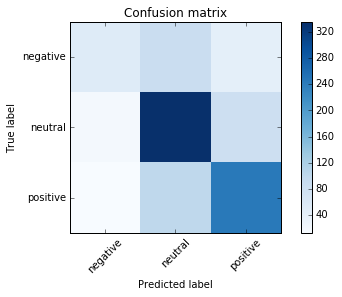

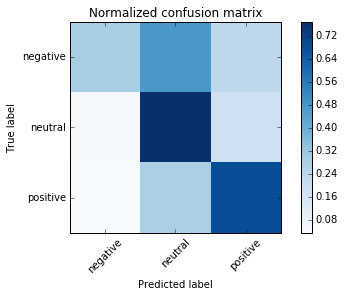

In [37]:
%matplotlib inline

y_pred = test_predictions
y_test= test_tweets['label']
target_names=('negative','neutral','positive')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('\nNormalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

Looks like most of the messages categorized as 'negative' will be predicted as 'neutral', almost 50%. only 29 % of the 'negative' tweets are predicted as 'negative. Other categories will be predicted more precisely to the correct categories.

Let's check the classification report next.

#### Classification report.

In [38]:
print classification_report(test_tweets['label'], test_predictions)

             precision    recall  f1-score   support

   negative       0.62      0.29      0.39       181
    neutral       0.64      0.77      0.70       436
   positive       0.66      0.68      0.67       357

avg / total       0.65      0.65      0.63       974



This is the prediction of how well the model would predict any unseen Twitter messages. Twitter messages with 'positive' and 'negative' labels are predicted quite well, but like noted above, the problematic category is the 'negative'.

#### Final evaluation with the given evaluation code.

In [39]:
print 'Evaluation F-score calculated with the given functions:'
evaluation_modified(test_tweets['label'], test_predictions)

Evaluation F-score calculated with the given functions:
F-score: 0.532314569364


The result is over 0.5, but quite far from 0.6 (or 0.7). In other words the result is feasible, but could be better.

Problem clearly is that the tweets labeles 'negative' are not recognized as negative. Haven't looked any deeper into the messages, but it might be some semantic issue with separate words, or actually lemmas in this case.

With my earlier tries of modelling, the LinearSVC could not predict anything to 'negative' class. So taken that into account, I am very happy with this model, and the learning process.

### Saving the classifier with pickle

The model is stored and can be opened without additional fitting for any new testing predictions. Note! The Twitter message preprocessing and vectorizing needs to be done too, so the model alone does not give similar results.

In [40]:
save_classifier=open("clf_tweets.pickle", "wb") #write in bytes
pickle.dump(clf, save_classifier)
save_classifier.close()

# References

## Original code that was given for evaluation

In [41]:
from collections import defaultdict
import codecs
import argparse

def evaluate(true_path, prediction_path):
    true_handle = codecs.open(true_path, 'r', 'utf-8')
    prediction_handle = codecs.open(prediction_path, 'r', 'utf-8')
    
    true_labels = [line.split('\t')[2] for line in true_handle.readlines()]
    predicted_labels = [line.split('\t')[2] for line in prediction_handle.readlines()]
    
    print "F-score: %s" % _macro_f_score(true_labels, predicted_labels)
    

def _macro_f_score(true_labels, predicted_labels):
    """
    Mimics the official SemEval evaluation,
    which calculates the macro-averaged f-score of positive and negative class.
    Neutral class is ignored.
    The input should be lists or other iterable types (e.g. numpy arrays).
    """
    
    counts = defaultdict(lambda:defaultdict(int))
    
    for i in range(len(true_labels)):
        if predicted_labels[i] == true_labels[i] and predicted_labels[i]\
        in ['positive', 'negative']:
            counts[predicted_labels[i]]['tp'] += 1
        elif predicted_labels[i] != true_labels[i] and predicted_labels[i]\
        in ['positive', 'negative']:
            counts[predicted_labels[i]]['fp'] += 1
            
    counts['positive']['all_true'] = list(true_labels).count('positive')
    counts['negative']['all_true'] = list(true_labels).count('negative')

    try:
        precision_positive = float(counts['positive']['tp']) / \
        (counts['positive']['tp'] + counts['positive']['fp'])
        recall_positive = float(counts['positive']['tp']) / \
        counts['positive']['all_true']
        f_score_positive = 2 * precision_positive * recall_positive / \
        (precision_positive + recall_positive)
    except:
        f_score_positive = 0.0
    
    try:
        precision_negative = float(counts['negative']['tp']) / \
        (counts['negative']['tp'] + counts['negative']['fp'])
        recall_negative = float(counts['negative']['tp']) / \
        counts['negative']['all_true']
        f_score_negative = 2 * precision_negative * recall_negative /\
        (precision_negative + recall_negative)
    except:
        f_score_negative = 0.0
    
    
    return (f_score_positive + f_score_negative) / 2.0

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Twitter sentiment evaluator script.')
    parser.add_argument('--true', help='Path to true labels', required=True)
    parser.add_argument('--predictions', help='Path to predicted labels', required=True)
    
    args = vars(parser.parse_args())
    
    evaluate(args['true'], args['predictions'])

usage: __main__.py [-h] --true TRUE --predictions PREDICTIONS
__main__.py: error: argument --true is required


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.


## Other references and sources used

Together with course slides, several internet sources were used. The sources that were probably most used were scikit-learn library documentation and this web page: http://radimrehurek.com/data_science_python/